# Traffic Sign Recognition with Tensorflow

The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. 


## First Objective: Traffic Sign Classification

I'll start with a simple goal: classifictions. Given an image of a traffic sign, our model should be able to tell it's type (e.g. Stop sign, speed limit, yield sign, ...etc.). We'll work with images that are properly cropped such that the traffic sign takes most of the image.


For this project, I'm using Pythong 3.5, Tensorflow 0.11, Numpy, Sci-kit Image, and Matplotlib. All pretty standard tools in machine learning.

First step, let's import the needed libraries and get that out of the way.

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.13.1


## Training Dataset

We're using the Belgian Traffic Sign Dataset. Go to http://btsd.ethz.ch/shareddata/ and download the training and test data. There is a lot of datasets on that page, but you only need the two files listed under **BelgiumTS for Classification (cropped images)**":	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

After downloading and expanding the files, your directory structure should look something like this:

```
/irfanasrullah/datasets/Training/
/irfanasrullah/datasets/Testing/
```

Each of the two directories above has 62 sub-directories named sequentially from 00000 to 00062. The directory name represents the code (or label) and the images inside the directory are examples of that label. 

## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "datasets"
train_data_dir = os.path.join(ROOT_PATH, "Training")
test_data_dir = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_dir)

## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [3]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "datasets"
train_data_dir = os.path.join(ROOT_PATH, "Training")
test_data_dir = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_dir)

Here we're loading two lists:
* **images** a list of images, each image is represted by a numpy array.
* **labels** a list of labels. Integers with values between 0 and 61.


It's not usually a good idea to load the whole dataset into memory, but this dataset is small and we're trying to keep the code simple, so it's okay for now. We'll improve it in the next part. For larger datasets, we'd want to have a separate thread loading chunks of data in the background and feeding them to the training thread. 

## Explore the Dataset

How many images and labels do we have?

In [4]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 3
Total Images: 445


Display the first image of each label.

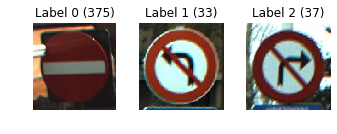

In [5]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

That looks great! The traffic signs occupy most of the area of each image, which is going to make our job easier: we don't have to look for the sign in the image. And we have a variety of angles and lighting conditions, which will help our model generalize. 

However, although the images are square-ish, they're not all the same size. They have different aspect ratios. Our simple neural network takes a fixed-size input, so we have a bit of pre-processing to do. We'll get to that soon, but first let's pick a label and see more of it's images. Let's pick label 32:

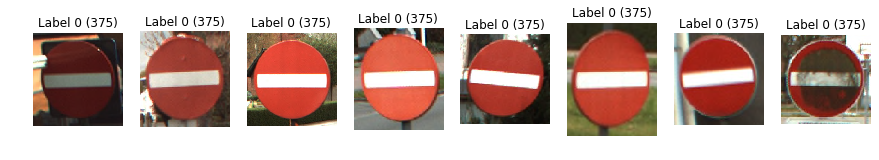

In [6]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 8  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(1, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 0)

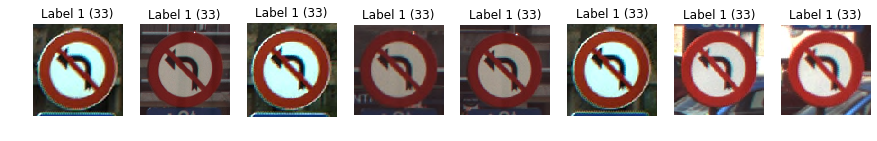

In [7]:
display_label_images(images, 1)

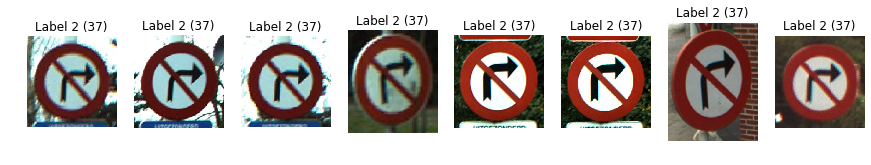

In [8]:
display_label_images(images, 2)

Interesting! It looks like our dataset considers all speeding limit signs to be of the same class regardless of the numbers on them. That's fine, as long as we know about it beforehand and don't let it confuse us later when the output doesn't match our expectation. 

I'll leave exploring other labels as an exercise for you, edit the code above and check other labels. Make sure to check Labels 26 and 27. They also have numbers in a red circle, so our model will have to get really good to differentiate between these 3 classes.

## Handling images of different sizes?

Most neural networks expect a fixed-size input, and our network is no exception. But as we've seen above, our images are not all the same size. A common approach is to crop and pad the images to a selected apect ratio, but then we have to make sure that we don't cut-off parts of the traffic signs in the process. That seems like it might require manual work! Let's do a simpler solution instead (a hack really): We'll just resize the images to a fixed size and ignore the distortions caused by the different aspect ratios. A person can easily recognize a traffic sign even if it's compressed or stretched a bit, so we hope that our model can as well. 

And while we're at it, let's make the images smaller. The larger the input data, the larger the model, and the slower it is to train. In the early stages of development we want fast training to avoid long waits between iterations while we change the code rapidly. 

What are the sizes of our image anyway?

In [9]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (136, 130, 3), min: 5, max: 255
shape: (144, 133, 3), min: 18, max: 255
shape: (264, 253, 3), min: 0, max: 255
shape: (139, 121, 3), min: 0, max: 255
shape: (147, 145, 3), min: 0, max: 255


The sizes seem to hover around 128x128. If we resize them to, say, 32x32, we'll have reduced the data and the model size by a factor of 16. And 32x32 is probably still big enough to recognize the signs, so let's go with that. 

I'm also in the habit of frequently printing the min() and max() values. It's a simple way to verify the range of your data and catch bugs early.

/Users/irfanasrullah/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


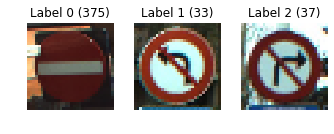

In [10]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [11]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.029932598039215982, max: 1.0
shape: (32, 32, 3), min: 0.07296262254901931, max: 1.0
shape: (32, 32, 3), min: 0.053538602941176405, max: 1.0
shape: (32, 32, 3), min: 0.03247740502451053, max: 1.0
shape: (32, 32, 3), min: 0.02386546415441181, max: 1.0


The 32x32 images are not as sharp but still recognizable. Note that the display above shows the images larger than their real size because the matplotlib library tries to fit them to the grid size. Let's print the sizes of a few images to verify that we got it right.

for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

The sizes are correct. But check the min and max values! They now range from 0 to 1.0, which is different from the 0-255 range we saw above. The resizing function did that transformation for us. Normalizing values to the range 0.0-1.0 is very common so we'll keep it. But remember to multiply by 255 if you later want to convert the images back to the normal 0-255 range.

# Minimum Viable Model

In [12]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (445,) 
images:  (445, 32, 32, 3)


In [13]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 3072), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


## Training

In [14]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [15]:
for i in range(501):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Epoch: ", i/10, "Loss: ", loss_value)

Epoch:  0.0 Loss:  4.3063393
Epoch:  1.0 Loss:  0.4056107
Epoch:  2.0 Loss:  0.18710382
Epoch:  3.0 Loss:  0.110686496
Epoch:  4.0 Loss:  0.07873096
Epoch:  5.0 Loss:  0.06195796
Epoch:  6.0 Loss:  0.05190322
Epoch:  7.0 Loss:  0.045034062
Epoch:  8.0 Loss:  0.039916765
Epoch:  9.0 Loss:  0.035855226
Epoch:  10.0 Loss:  0.032517944
Epoch:  11.0 Loss:  0.029710375
Epoch:  12.0 Loss:  0.027305108
Epoch:  13.0 Loss:  0.025216632
Epoch:  14.0 Loss:  0.023384072
Epoch:  15.0 Loss:  0.021762038
Epoch:  16.0 Loss:  0.020315817
Epoch:  17.0 Loss:  0.019018415
Epoch:  18.0 Loss:  0.017848263
Epoch:  19.0 Loss:  0.016788008
Epoch:  20.0 Loss:  0.015823493
Epoch:  21.0 Loss:  0.014942888
Epoch:  22.0 Loss:  0.014136326
Epoch:  23.0 Loss:  0.013395455
Epoch:  24.0 Loss:  0.012713147
Epoch:  25.0 Loss:  0.012083213
Epoch:  26.0 Loss:  0.011500372
Epoch:  27.0 Loss:  0.010959955
Epoch:  28.0 Loss:  0.010457923
Epoch:  29.0 Loss:  0.009990691
Epoch:  30.0 Loss:  0.00955507
Epoch:  31.0 Loss:  0.00914

## Using the Model

The session object contains the values of all the variables in our model (i.e. the weights). 

In [16]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 20)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2]
[0 0 2 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 1 2]


In [17]:
print(sample_images)

[array([[[0.99971852, 1.        , 0.9987994 ],
        [1.        , 0.99581993, 0.99215686],
        [0.99509995, 1.        , 0.99969554],
        ...,
        [0.94043926, 0.85802505, 0.7444221 ],
        [0.78857613, 0.60617532, 0.48306143],
        [0.32487745, 0.2459195 , 0.20486558]],

       [[1.        , 0.99607843, 0.9997415 ],
        [1.        , 0.99607843, 0.99889706],
        [1.        , 0.99656288, 1.        ],
        ...,
        [0.98966184, 0.92120672, 0.81544692],
        [0.81693091, 0.62185394, 0.50882353],
        [0.42301049, 0.31532437, 0.27452895]],

       [[0.9925877 , 1.        , 1.        ],
        [0.99938151, 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.99842027, 0.97478745, 0.88372396],
        [0.83744447, 0.73143957, 0.61201555],
        [0.51017348, 0.41017157, 0.34074563]],

       ...,

       [[0.41292892, 0.42469363, 0.21292892],
        [0.42529488, 0.43889782, 0.22658739],
        [0.40497281, 

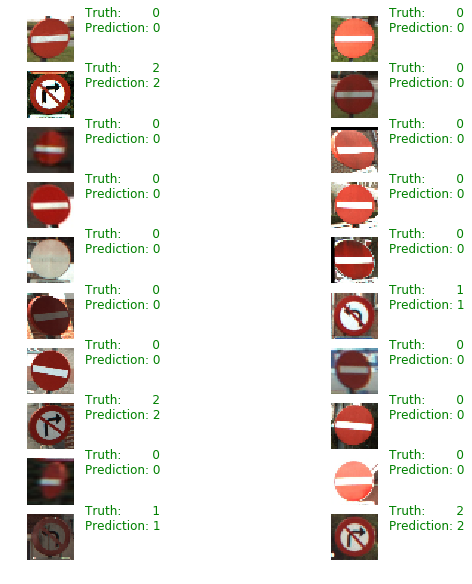

In [18]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(10, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


## Evaluation

It's fun to visualize the results, but we need a more precise way to measure the accuracy of our model. Also, it's important to test it on images that it hasn't seen. And that's where the validation data set comes into play.

In [19]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)

/Users/irfanasrullah/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


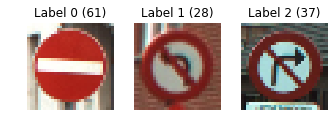

In [20]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images32, test_labels)

In [21]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.984
